In [1]:
import torch
import torch.nn as nn # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F # All functions that don't have any parameters
from torch.autograd import Variable

from sklearn.metrics.pairwise import rbf_kernel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from quantile_forest import RandomForestQuantileRegressor


import cvxpy as cp
import numpy as np
from numpy import linalg
import pandas as pd

from scipy.linalg import sqrtm


from matplotlib import pyplot as plt

import seaborn as sns
import matplotlib.patches as patches
import matplotlib.lines as lines

import warnings
random_seed = 42


if torch.cuda.is_available():
    print("GPU is available.")
    device = torch.device('cuda')
else:
    print("GPU is not available.")
    device = torch.device('cpu')

GPU is not available.


In [2]:
class NN1(nn.Module):
    def __init__(self, input_size, output_size):
        super(NN1, self).__init__()
        self.fc1 = nn.Linear(input_size, 10)
        self.fc2 = nn.Linear(10, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
# 2-layer NN
class NN2(nn.Module):
    def __init__(self, input_size, output_size):
        super(NN2, self).__init__()
        self.fc1 = nn.Linear(input_size, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x 

In [3]:
class QuantileLoss(nn.Module):
    def __init__(self, quantile):
        super().__init__()
        self.quantile = quantile

    def forward(self, preds, target):
        assert not target.requires_grad
        assert preds.size(0) == target.size(0)
        residuals = target - preds
        return torch.max((self.quantile - 1) * residuals, self.quantile * residuals).mean()
        
        
def est_quantile(est_type,quantile,X_pre,Y_pre,X_opt,X_adj,X_t):
    """
        est_type: 
        "NN1": 1-layer NN;              "NN2": 2-layer NN; 
        "qrf": quantile regression forest;    "gb": gradient boosting
        
        quantile: the quantile we are estimating
        (X_pre,Y_pre): training data
        X_opt,X_adj,X_t: data used to predict
        output: quantile estimator Q and the prediction Q(X) 
    """
    
    if est_type == "NN1":
        torch.manual_seed(42)
        torch.cuda.manual_seed_all(42)
        
        # Convert numpy arrays to torch tensors
        X = torch.from_numpy(X_pre).float().to(device)
        Y = torch.from_numpy(Y_pre).float().to(device)
        
        model = NN1(input_size=5, output_size=1).to(device)
        learning_rate = 0.001
        
        # Set loss function and optimizer
        criterion = QuantileLoss(quantile).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        
        # Training loop
        for epoch in range(1000):
            optimizer.zero_grad()   # zero the gradient buffers
            output = model(X)
            loss = criterion(output, Y)
            loss.backward()
            optimizer.step()    # Does the update
            
        # Predict
        X_opt = torch.from_numpy(X_opt).float().to(device)
        X_adj = torch.from_numpy(X_adj).float().to(device)
        X_t = torch.from_numpy(X_t).float().to(device)

        Q_opt = model(X_opt)
        Q_opt = Q_opt.detach().cpu().numpy().reshape(-1,1)
        Q_adj = model(X_adj)
        Q_adj = Q_adj.detach().cpu().numpy().reshape(-1,1)
        Q_t = model(X_t)
        Q_t = Q_t.detach().cpu().numpy().reshape(-1,1)
        return model, Q_opt, Q_adj, Q_t
    
    if est_type == "NN2":
        torch.manual_seed(42)
        torch.cuda.manual_seed_all(42) 
        
        # Convert numpy arrays to torch tensors
        X = torch.from_numpy(X_pre).float().to(device)
        Y = torch.from_numpy(Y_pre).float().to(device)
        
        model = NN2(input_size=5, output_size=1).to(device)
        learning_rate = 0.001
        
        # Set loss function and optimizer
        criterion = QuantileLoss(quantile).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        
        # Training loop
        for epoch in range(1000):
            optimizer.zero_grad()   # zero the gradient buffers
            output = model(X)
            loss = criterion(output, Y)
            loss.backward()
            optimizer.step()    # Does the update
            
        # Predict
        X_opt = torch.from_numpy(X_opt).float().to(device)
        X_adj = torch.from_numpy(X_adj).float().to(device)
        X_t = torch.from_numpy(X_t).float().to(device)

        Q_opt = model(X_opt)
        Q_opt = Q_opt.detach().cpu().numpy().reshape(-1,1)
        Q_adj = model(X_adj)
        Q_adj = Q_adj.detach().cpu().numpy().reshape(-1,1)
        Q_t = model(X_t)
        Q_t = Q_t.detach().cpu().numpy().reshape(-1,1)
        return model, Q_opt, Q_adj, Q_t
    
    if est_type == "qrf":
        model = RandomForestQuantileRegressor(n_estimators = 500, random_state=random_seed)
        model.fit(X_pre, Y_pre)
        Q_opt = model.predict(X_opt,quantiles = [quantile]).reshape(-1,1)
        Q_adj = model.predict(X_adj,quantiles = [quantile]).reshape(-1,1)
        Q_t = model.predict(X_t,quantiles = [quantile]).reshape(-1,1)
        return model, Q_opt, Q_adj, Q_t
    
    
    if est_type == "gb":
        model = GradientBoostingRegressor(n_estimators=300,random_state=random_seed,loss = "quantile", alpha = quantile)
        model.fit(X_pre, Y_pre)
        Q_opt = model.predict(X_opt).reshape(-1,1)
        Q_adj = model.predict(X_adj).reshape(-1,1)
        Q_t = model.predict(X_t).reshape(-1,1)
        return model, Q_opt, Q_adj, Q_t


In [4]:
data = pd.read_csv('airfoil_self_noise.csv', header = None,sep='\t')
Data = data.to_numpy()

Data[:,0] = np.log(Data[:,0]) # log transform
Data[:,4] = np.log(Data[:,4]) # log transform

beta = np.array([-1, 0, 0, 0, 1])

def mydata(Data, beta, prop = 0.75):
    
    # random split the data from source into two parts: training and testing data
    np.random.shuffle(Data)
    train_idx = int(Data.shape[0] * prop)
    Dtrain, Dtest = np.split(Data, [train_idx])
    
    # creat the shift data set
    probabilities = np.exp(Dtest[:,0:5].dot(beta)) # Calculate probabilities proportional to w(x) = exp(x^T * beta)
    probabilities /= np.sum(probabilities) # Normalize probabilities
    
    sample_indices = np.random.choice(len(Dtest), size=len(Dtest), replace=True, p=probabilities)
    Dshift = Dtest[sample_indices]
    
    return Dtrain, Dtest, Dshift

In [ ]:
mc_iteration = 200
bandwidth = np.zeros(mc_iteration)
coverage = np.zeros(mc_iteration)

for j in range(mc_iteration):
    Dtrain, Dtest, Dshift = mydata(Data, beta)

    Y_train = Dtrain[:,5]
    X_train = Dtrain[:,0:5]

    X_test = Dshift[:,0:5]
    Y_test = Dshift[:,5]


    pre_idx = int(Dtrain.shape[0] * 0.5)
    Dtrain_pre, Dtrain_opt = np.split(Dtrain, [pre_idx])
    adj_idx = int(Dtrain_opt.shape[0] * 0.5)
    Dtrain_opt, Dtrain_adj = np.split(Dtrain_opt, [adj_idx])

    X_pre = Dtrain_pre[:,0:5]
    Y_pre = Dtrain_pre[:,5]

    X_opt = Dtrain_opt[:,0:5]
    Y_opt = Dtrain_opt[:,5]

    X_adj = Dtrain_adj[:,0:5]
    Y_adj = Dtrain_adj[:,5]
    
    mean_model = RandomForestRegressor(n_estimators = 1000, random_state = 42)
    mean_model.fit(X_pre, Y_pre)

    mean_est_pre = mean_model.predict(X_pre)
    mean_est_opt = mean_model.predict(X_opt)
    mean_est_adj = mean_model.predict(X_adj)

    Y_centered_squared_pre = (Y_pre - mean_est_pre)**2 
    Y_centered_squared_opt = (Y_opt - mean_est_opt)**2 
    Y_centered_squared_adj = (Y_adj - mean_est_adj)**2 
    
    quantile = [0.95,0.95,0.95,0.95]


    m1,Q1_opt,Q1_adj,Q1_t = est_quantile("NN1",quantile[0],X_pre,Y_centered_squared_pre,X_opt,X_adj,X_test) # quantile def
    m2,Q2_opt,Q2_adj,Q2_t = est_quantile("NN2",quantile[1],X_pre,Y_centered_squared_pre,X_opt,X_adj,X_test)
    m3,Q3_opt,Q3_adj,Q3_t = est_quantile("qrf",quantile[2],X_pre,Y_centered_squared_pre,X_opt,X_adj,X_test)
    m4,Q4_opt,Q4_adj,Q4_t = est_quantile("gb",quantile[3],X_pre,Y_centered_squared_pre,X_opt,X_adj,X_test)
    

    ######## Variance estimator ###########
    
    rf_var_model = RandomForestRegressor(n_estimators = 1000, random_state = 42)
    rf_var_model.fit(X_pre, Y_centered_squared_pre)
    var_hat_pre = rf_var_model.predict(X_pre)
    var_hat_adj = rf_var_model.predict(X_adj)
    var_hat_opt = rf_var_model.predict(X_opt)
    var_hat_test = rf_var_model.predict(X_test)
    
    E_opt = np.vstack((np.matrix.flatten(Q1_opt), np.matrix.flatten(Q2_opt), np.matrix.flatten(Q3_opt), np.matrix.flatten(Q4_opt), var_hat_opt))
    E_adj = np.vstack((np.matrix.flatten(Q1_adj), np.matrix.flatten(Q2_adj), np.matrix.flatten(Q3_adj), np.matrix.flatten(Q4_adj), var_hat_adj))
    E_test = np.vstack((np.matrix.flatten(Q1_t), np.matrix.flatten(Q2_t), np.matrix.flatten(Q3_t), np.matrix.flatten(Q4_t), var_hat_test))
    
    n_opt = X_opt.shape[0]
    n_adj = X_adj.shape[0]
    n_test = X_test.shape[0]

    cons_opt = np.ones(n_opt).reshape(1,-1)
    cons_adj = np.ones(n_adj).reshape(1,-1)
    cons_test = np.ones(n_test).reshape(1,-1)

    A_opt = np.vstack((E_opt,cons_opt))
    A_adj = np.vstack((E_adj,cons_adj))
    A_test = np.vstack((E_test,cons_test))

    weight = cp.Variable(A_opt.shape[0])


    constraints = [weight>=0]+[weight @ A_opt >= Y_centered_squared_opt]  ### Change the objective 
    prob = cp.Problem(cp.Minimize(cp.sum(weight @ A_test)), constraints)
    prob.solve()
    optimal_weight = weight.value

    f_hat_init_opt = optimal_weight @  A_opt
    f_hat_init_adj = optimal_weight @  A_adj
    f_hat_init_test = optimal_weight @ A_test
    
    domain_cov = np.vstack((X_pre, X_test))
    domain_idx =  np.vstack((np.zeros(X_pre.shape[0]).reshape(-1,1), np.ones(X_test.shape[0]).reshape(-1,1)))
    domain_idx = np.matrix.flatten(domain_idx)

    logistic_model = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000,random_state=0) 
    logistic_model.fit(domain_cov, domain_idx)

    prob_hat = logistic_model.predict_proba(X_adj)[:,0]
    prob_hat = np.clip(prob_hat, 0.01, 0.99)
    est_ratio = prob_hat/(1-prob_hat)
    
    delta = 1.01
    alpha = 0.05
    stepsize = 0.005
    prop_outside = np.mean(est_ratio * ((Y_centered_squared_adj/f_hat_init_adj) > delta))
    while prop_outside <= alpha:
        delta = delta - stepsize
        prop_outside = np.mean(est_ratio * ((Y_centered_squared_adj/f_hat_init_adj) > delta))
        
    mean_est_test = mean_model.predict(X_test)
    Y_centered_squared_test = (Y_test - mean_est_test)**2 
    coverage[j] = np.mean(Y_centered_squared_test < (delta * f_hat_init_test))
    bandwidth[j] = 2 * np.mean((delta * f_hat_init_test) ** 0.5)
    print(j, " th iteration is done!")
    print("The value of delta is",delta)

In [ ]:
sns.histplot(np.array(coverage).reshape(-1, 1), kde = True, bins = 30)

In [ ]:
sns.histplot(np.array(bandwidth).reshape(-1, 1), kde = True,bins = 30)

In [13]:
def run_utopia(mc_iter):
    Dtrain, Dtest, Dshift = mydata(Data, beta)
    Y_train = Dtrain[:,5]
    X_train = Dtrain[:,0:5]

    X_test = Dshift[:,0:5]
    Y_test = Dshift[:,5]


    pre_idx = int(Dtrain.shape[0] * 0.5)
    Dtrain_pre, Dtrain_opt = np.split(Dtrain, [pre_idx])
    adj_idx = int(Dtrain_opt.shape[0] * 0.5)
    Dtrain_opt, Dtrain_adj = np.split(Dtrain_opt, [adj_idx])

    X_pre = Dtrain_pre[:,0:5]
    Y_pre = Dtrain_pre[:,5]

    X_opt = Dtrain_opt[:,0:5]
    Y_opt = Dtrain_opt[:,5]

    X_adj = Dtrain_adj[:,0:5]
    Y_adj = Dtrain_adj[:,5]
    
    mean_model = RandomForestRegressor(n_estimators = 1000, random_state = 42)
    mean_model.fit(X_pre, Y_pre)

    mean_est_pre = mean_model.predict(X_pre)
    mean_est_opt = mean_model.predict(X_opt)
    mean_est_adj = mean_model.predict(X_adj)

    Y_centered_squared_pre = (Y_pre - mean_est_pre)**2 
    Y_centered_squared_opt = (Y_opt - mean_est_opt)**2 
    Y_centered_squared_adj = (Y_adj - mean_est_adj)**2 
    
    quantile = [0.85,0.95,0.9,0.9]


    m1,Q1_opt,Q1_adj,Q1_t = est_quantile("NN1",quantile[0],X_pre,Y_centered_squared_pre,X_opt,X_adj,X_test) # quantile def
    m2,Q2_opt,Q2_adj,Q2_t = est_quantile("NN2",quantile[1],X_pre,Y_centered_squared_pre,X_opt,X_adj,X_test)
    m3,Q3_opt,Q3_adj,Q3_t = est_quantile("qrf",quantile[2],X_pre,Y_centered_squared_pre,X_opt,X_adj,X_test)
    m4,Q4_opt,Q4_adj,Q4_t = est_quantile("gb",quantile[3],X_pre,Y_centered_squared_pre,X_opt,X_adj,X_test)
    

    ######## Variance estimator ###########
    
    rf_var_model = RandomForestRegressor(n_estimators = 1000, random_state = 42)
    rf_var_model.fit(X_pre, Y_centered_squared_pre)
    var_hat_pre = rf_var_model.predict(X_pre)
    var_hat_adj = rf_var_model.predict(X_adj)
    var_hat_opt = rf_var_model.predict(X_opt)
    var_hat_test = rf_var_model.predict(X_test)
    
    E_opt = np.vstack((np.matrix.flatten(Q1_opt), np.matrix.flatten(Q2_opt), np.matrix.flatten(Q3_opt), np.matrix.flatten(Q4_opt), var_hat_opt))
    E_adj = np.vstack((np.matrix.flatten(Q1_adj), np.matrix.flatten(Q2_adj), np.matrix.flatten(Q3_adj), np.matrix.flatten(Q4_adj), var_hat_adj))
    E_test = np.vstack((np.matrix.flatten(Q1_t), np.matrix.flatten(Q2_t), np.matrix.flatten(Q3_t), np.matrix.flatten(Q4_t), var_hat_test))
    
    n_opt = X_opt.shape[0]
    n_adj = X_adj.shape[0]
    n_test = X_test.shape[0]

    cons_opt = np.ones(n_opt).reshape(1,-1)
    cons_adj = np.ones(n_adj).reshape(1,-1)
    cons_test = np.ones(n_test).reshape(1,-1)

    A_opt = np.vstack((E_opt,cons_opt))
    A_adj = np.vstack((E_adj,cons_adj))
    A_test = np.vstack((E_test,cons_test))

    weight = cp.Variable(A_opt.shape[0])


    constraints = [weight>=0]+[weight @ A_opt >= Y_centered_squared_opt]  ### Change the objective 
    prob = cp.Problem(cp.Minimize(cp.sum(weight @ A_test)), constraints)
    prob.solve()
    optimal_weight = weight.value

    f_hat_init_opt = optimal_weight @  A_opt
    f_hat_init_adj = optimal_weight @  A_adj
    f_hat_init_test = optimal_weight @ A_test
    
    domain_cov = np.vstack((X_pre, X_test))
    domain_idx =  np.vstack((np.zeros(X_pre.shape[0]).reshape(-1,1), np.ones(X_test.shape[0]).reshape(-1,1)))
    domain_idx = np.matrix.flatten(domain_idx)

    logistic_model = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000,random_state=0) 
    logistic_model.fit(domain_cov, domain_idx)

    prob_hat = logistic_model.predict_proba(X_adj)[:,0]
    prob_hat = np.clip(prob_hat, 0.01, 0.99)
    est_ratio = prob_hat/(1-prob_hat) #### Multiplying by the constant or normalization #####
    #est_ratio /= est_ratio.mean()
    est_ratio = est_ratio * (X_pre.shape[0]/X_test.shape[0])
    
    
    delta = 1.01
    alpha = 0.05
    stepsize = 0.005
    prop_outside = np.mean(est_ratio * ((Y_centered_squared_adj/f_hat_init_adj) > delta))
    while prop_outside <= alpha:
        delta = delta - stepsize
        prop_outside = np.mean(est_ratio * ((Y_centered_squared_adj/f_hat_init_adj) > delta))
        
    mean_est_test = mean_model.predict(X_test)
    Y_centered_squared_test = (Y_test - mean_est_test)**2 
    cov = np.mean(Y_centered_squared_test < (delta * f_hat_init_test))
    bw = 2 * np.mean((delta * f_hat_init_test) ** 0.5)
    return cov, bw

In [14]:
from joblib import Parallel, delayed
results = Parallel(n_jobs=10)(delayed(run_utopia)(mc_iter) for mc_iter in range(200))

/var/folders/8h/91p3j8752c13k8tln_mp4lbw00dncy/T/ipykernel_57253/673238192.py:106: RuntimeWarning: invalid value encountered in sqrt


In [15]:
coverage = np.array(results)[:,0]
bandwidth = np.array(results)[:,1]

In [16]:
coverage.mean()

0.9610505319148936

Text(0.5, 0, 'Coverage--Our method')

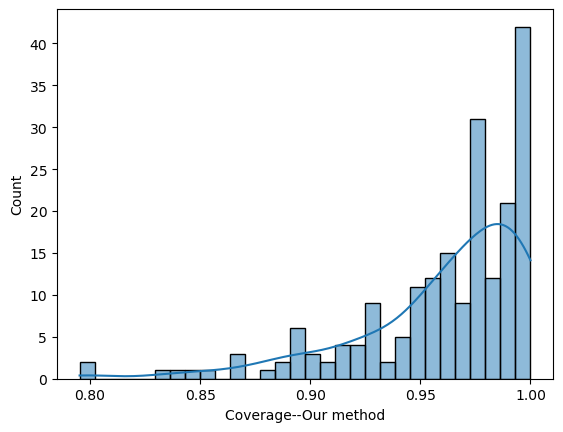

In [17]:
sns.histplot(np.array(coverage).reshape(-1, 1), kde = True, bins = 30, legend = False)
plt.xlabel('Coverage--Our method')

Text(0.5, 0, 'Bandwidth--Our method')

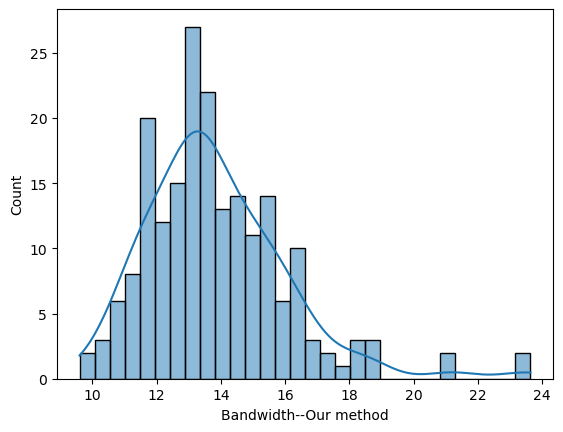

In [20]:
sns.histplot(np.array(bandwidth).reshape(-1, 1), kde = True,bins = 30, legend = False)
plt.xlabel('Bandwidth--Our method')

In [25]:
np.nanmean(bandwidth[coverage > 0.95]) 

14.350432456969925

In [32]:
np.sqrt(np.ma.masked_invalid(bandwidth[coverage >= 0.95]).var())

2.2235266267294307

In [28]:
np.savetxt('Coverage_Ours_200.csv', coverage, delimiter=',')
np.savetxt('Bandwidth_Ours_200.csv', bandwidth, delimiter=',')